In [1]:
# If running on Colab, uncomment the next lines
import tensorflow as tf


device_name = tf.test.gpu_device_name()
print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))

GPU not found.


In [2]:
import tensorflow as tf
from utils.u_net.dataset_functions import create_dataset, unwrap_client_data, create_dataset_lazy, create_tf_dataset
from utils.u_net.image_processing import *
from utils.u_net.unet import initialize_unet
from utils.u_net.federated_averaging import federated_averaging
from utils.u_net.visualization import visualize_results_testset

In [3]:
data_dir = 'data_train/'
imagePath0 = f'{data_dir}/0/'
imagePath1 = f'{data_dir}/1/'
npyPath = f'{data_dir}/annotations/'

# merged_data 폴더의 파일들을 8개 클라이언트에 균등하게 분배
# 총 3744개 파일을 8개 클라이언트에 각각 468개씩 분배
total_files = 600
num_clients = 6
files_per_client = total_files // num_clients

clientIdentifierDict = {}
start = 1

for i in range(1, num_clients + 1):
    if i < num_clients:
        end = start + files_per_client - 1
    else:
        end = total_files  # 마지막 클라이언트는 나머지 모든 파일 포함
    
    # 파일 이름 리스트 생성 (000001, 000002, ... 형식)
    file_list = [f'{j:06d}' for j in range(start, end + 1)]
    clientIdentifierDict[f'client{i}'] = file_list
    print(f'client{i}: {start:06d} ~ {end:06d} ({len(file_list)}개 파일)')
    start = end + 1

datasetImageDict, datasetMaskDict = create_dataset(clientIdentifierDict, 
                                             imagePath0, imagePath1, npyPath, 
                                             tileSize = 128)


client1: 000001 ~ 000100 (100개 파일)
client2: 000101 ~ 000200 (100개 파일)
client3: 000201 ~ 000300 (100개 파일)
client4: 000301 ~ 000400 (100개 파일)
client5: 000401 ~ 000500 (100개 파일)
client6: 000501 ~ 000600 (100개 파일)

client1...
  처리 중: 50/100 파일 완료 (현재 타일 수: 1250)
  처리 중: 100/100 파일 완료 (현재 타일 수: 2500)
Contains 100 images...
Tiled Image Tensor Shape:  (2500, 128, 128, 2)
Tiled Mask Shape:  (2500, 128, 128)

client2...
  처리 중: 50/100 파일 완료 (현재 타일 수: 1250)
  처리 중: 100/100 파일 완료 (현재 타일 수: 2500)
Contains 100 images...
Tiled Image Tensor Shape:  (2500, 128, 128, 2)
Tiled Mask Shape:  (2500, 128, 128)

client3...
  처리 중: 50/100 파일 완료 (현재 타일 수: 8090)
  처리 중: 100/100 파일 완료 (현재 타일 수: 17890)
Contains 100 images...
Tiled Image Tensor Shape:  (17890, 128, 128, 2)
Tiled Mask Shape:  (17890, 128, 128)

client4...
  처리 중: 50/100 파일 완료 (현재 타일 수: 9800)
  처리 중: 100/100 파일 완료 (현재 타일 수: 19600)
Contains 100 images...
Tiled Image Tensor Shape:  (19600, 128, 128, 2)
Tiled Mask Shape:  (19600, 128, 128)

client5...


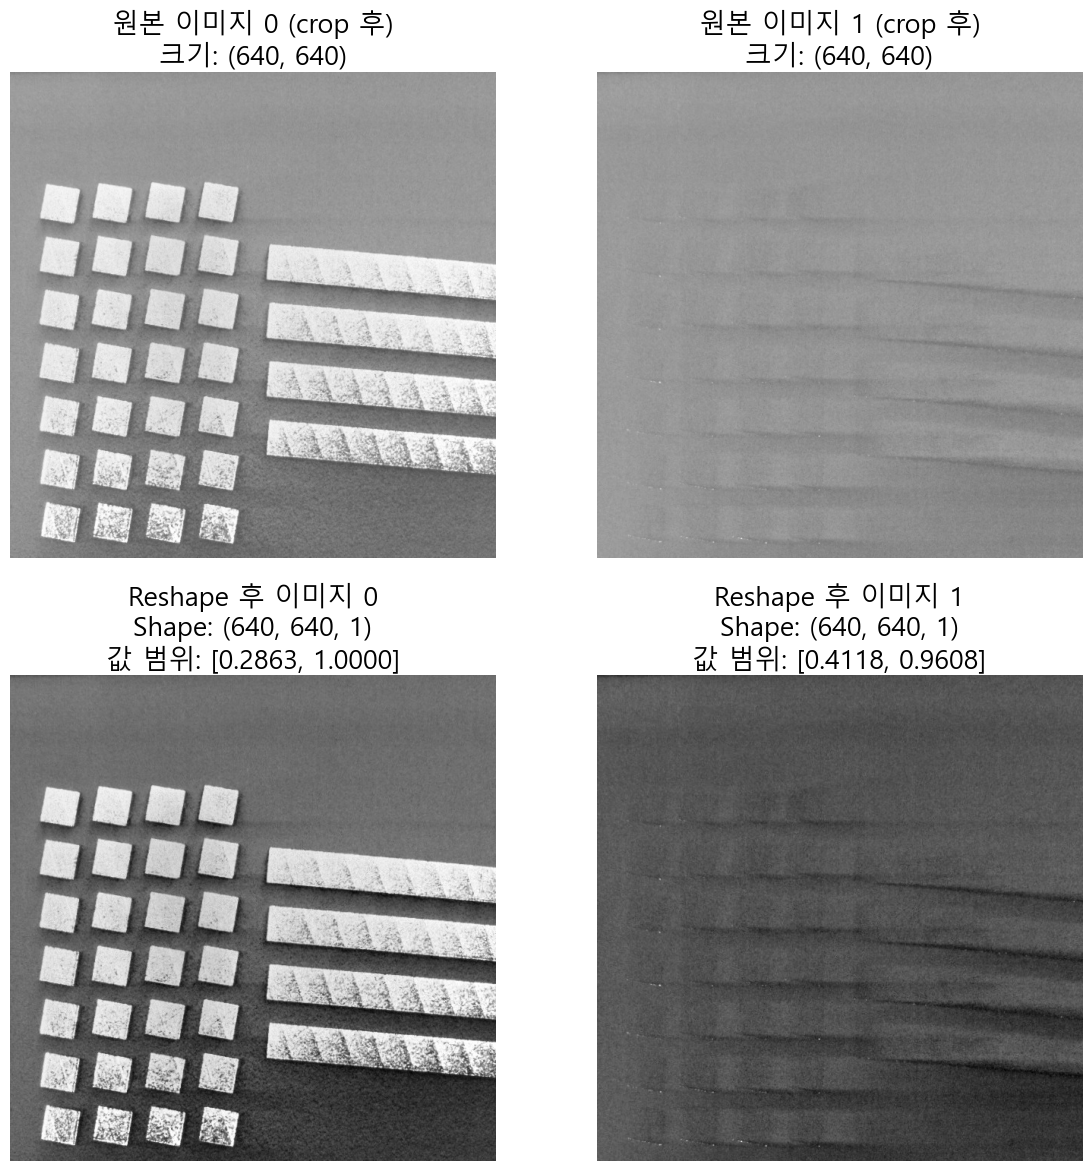


Reshape 후 상세 정보:
imtensor0 shape: (640, 640, 1)
imtensor1 shape: (640, 640, 1)
imtensor0 dtype: <dtype: 'float32'>
imtensor0 값 범위: [0.2863, 1.0000]
imtensor1 값 범위: [0.4118, 0.9608]
imtensor0 평균: 0.6290
imtensor1 평균: 0.5803


In [4]:
# Reshape 이후 이미지 출력
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows에서 한글 지원 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 첫 번째 파일로 테스트
test_file = '000001'
im0 = Image.open(imagePath0 + test_file + '.jpg')
im1 = Image.open(imagePath1 + test_file + '.jpg')
segmentationMask = np.load(npyPath + test_file + '.npy')

# 전처리 과정
tileSize = 128
rightcrop = im0.size[0]//tileSize * tileSize
bottomcrop = im0.size[1]//tileSize * tileSize
im0_cropped = im0.crop((0,0,rightcrop,bottomcrop))
im1_cropped = im1.crop((0,0,rightcrop,bottomcrop))
imarray0 = np.array(im0_cropped)
imarray1 = np.array(im1_cropped)

# RGB to Grayscale 변환
if len(imarray0.shape) == 3 and imarray0.shape[2] == 3:
    imarray0 = np.mean(imarray0, axis=2, keepdims=True)
elif len(imarray0.shape) == 2:
    imarray0 = np.expand_dims(imarray0, axis=2)

if len(imarray1.shape) == 3 and imarray1.shape[2] == 3:
    imarray1 = np.mean(imarray1, axis=2, keepdims=True)
elif len(imarray1.shape) == 2:
    imarray1 = np.expand_dims(imarray1, axis=2)

# Reshape 후
imtensor0 = tf.cast(imarray0.reshape(rightcrop, bottomcrop, 1), tf.float32)/255.0
imtensor1 = tf.cast(imarray1.reshape(rightcrop, bottomcrop, 1), tf.float32)/255.0

# 이미지 출력
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 원본 이미지 (crop 후)
axes[0, 0].imshow(im0_cropped)
axes[0, 0].set_title(f'원본 이미지 0 (crop 후)\n크기: {im0_cropped.size}')
axes[0, 0].axis('off')

axes[0, 1].imshow(im1_cropped)
axes[0, 1].set_title(f'원본 이미지 1 (crop 후)\n크기: {im1_cropped.size}')
axes[0, 1].axis('off')

# Reshape 후 이미지 (그레이스케일)
axes[1, 0].imshow(imtensor0[:, :, 0].numpy(), cmap='gray')
axes[1, 0].set_title(f'Reshape 후 이미지 0\nShape: {imtensor0.shape}\n값 범위: [{tf.reduce_min(imtensor0):.4f}, {tf.reduce_max(imtensor0):.4f}]')
axes[1, 0].axis('off')

axes[1, 1].imshow(imtensor1[:, :, 0].numpy(), cmap='gray')
axes[1, 1].set_title(f'Reshape 후 이미지 1\nShape: {imtensor1.shape}\n값 범위: [{tf.reduce_min(imtensor1):.4f}, {tf.reduce_max(imtensor1):.4f}]')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 추가 정보 출력
print("\n" + "="*60)
print("Reshape 후 상세 정보:")
print(f"imtensor0 shape: {imtensor0.shape}")
print(f"imtensor1 shape: {imtensor1.shape}")
print(f"imtensor0 dtype: {imtensor0.dtype}")
print(f"imtensor0 값 범위: [{tf.reduce_min(imtensor0):.4f}, {tf.reduce_max(imtensor0):.4f}]")
print(f"imtensor1 값 범위: [{tf.reduce_min(imtensor1):.4f}, {tf.reduce_max(imtensor1):.4f}]")
print(f"imtensor0 평균: {tf.reduce_mean(imtensor0):.4f}")
print(f"imtensor1 평균: {tf.reduce_mean(imtensor1):.4f}")
print("="*60)

In [ ]:
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5']
testClients = ['client6']

clientIDs, NCLIENTS = trainClients, len(trainClients)

Client Data is stored in two separate dictionaries, one for tiled image tensors (X) and other for segmentation masks (Y). Both dictionaries are keyed by `clientID`.

Training Dictionaries - `imageDict`(X) and `segMaskDict`(Y)

Testing Dictionaries - `imageDictTest`(X) and `segMaskDictTest`(Y)

In [6]:
# Train Data
imageDict, segMaskDict = {}, {}
for clientID in trainClients:
    imageDict[clientID] = datasetImageDict[clientID]
    segMaskDict[clientID] = datasetMaskDict[clientID]

# Test Data
imageDictTest, segMaskDictTest = {}, {}
for clientID in testClients:
    imageDictTest[clientID] = datasetImageDict[clientID]
    segMaskDictTest[clientID] = datasetMaskDict[clientID]
# unwrap test data from dictionary for easier model evaluation
testImages, testMasks = unwrap_client_data(imageDictTest, segMaskDictTest, testClients)

KeyError: 'client7'

In [ ]:
# Set hyperparameters for FL
# For demonstration, we use only 2 server rounds with 5 local epochs
SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE = 2, 5, 32, 8e-05

# Initialize the global model
model = initialize_unet()

In [ ]:
# Run (simulate) FL
# Please use GPU/Colab to avoid very long training time
# https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index
# https://colab.research.google.com/notebooks/gpu.ipynb

model, serverWeights, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(model,
                        SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE,
                        LOCAL_LEARNING_RATE,
                        clientIDs, imageDict, segMaskDict,
                        testImages, testMasks)

In [ ]:
# 학습 완료된 모델 저장
import os
from datetime import datetime

# saved_models 폴더가 없으면 생성
os.makedirs('saved_models', exist_ok=True)

# 파일명 생성: FL_ServerRounds_LocalEpochs_BatchSize_LearningRate_TestSet.h5
# 예: FL_2_5_32_8e05_HoldoutPart06.h5
test_set_name = ''.join([c.replace('client', '') for c in testClients])  # '6'
if len(test_set_name) == 1:
    test_set_name = '0' + test_set_name  # '06'

# Learning rate를 문자열로 변환 (8e-05 -> 8e05)
lr_str = f"{LOCAL_LEARNING_RATE:.0e}".replace('-', '').replace('+', '').replace('.0', '')

# 기본 파일명 생성
base_filename = f'saved_models/FL_{SERVER_ROUNDS}_{LOCAL_EPOCHS}_{LOCAL_BATCH_SIZE}_{lr_str}_HoldoutPart{test_set_name}.h5'

# 파일이 이미 존재하는지 확인하고, 존재하면 번호를 추가
model_filename = base_filename
counter = 1
while os.path.exists(model_filename):
    # 파일명에서 확장자 분리
    base_name, ext = os.path.splitext(base_filename)
    # 번호 추가: FL_2_5_32_8e05_HoldoutPart06_1.h5
    model_filename = f'{base_name}_{counter}{ext}'
    counter += 1

# 모델 저장
print(f'모델 저장 중: {model_filename}')
model.save(model_filename)
print(f'모델 저장 완료!')

# 최종 테스트 성능 출력
print(f'\n최종 테스트 성능:')
print(f'  Loss: {testLoss[-1]:.4f}')
print(f'  Accuracy: {testAccuracy[-1]:.4f}')

In [ ]:
fl_model = tf.keras.models.load_model('saved_models/FL_2_5_32_8e05_HoldoutPart06_1.h5')

visualize_results_testset(fl_model, imageDictTest, segMaskDictTest,
                              testClients, clientIdentifierDict)